In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
N = 1000  # Some were run with 5000 oops, so we'll just use 1000 for consistency

In [3]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [4]:
MODELS = [os.path.join('analysis_beams_v7.0', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_beams_v7.0'))]

In [5]:
MODELS_DESCRIPTION = {k: k.replace('v7.0_', '') for k in MODELS}

In [6]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [7]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [8]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [9]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [10]:
remove_invalid = []

for model, model_results in results.items():
    pbar = tqdm(model_results.items(), desc=f'Loading {model} results')
    for test_set, test_set_results in pbar:
        pbar.set_postfix_str(test_set)
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)
            
            for k, v in test_set_results['data'].items():
                test_set_results['data'][k] = v[:N]

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            keys_to_remove.extend(['x', 'y'])

            for k in keys_to_remove:
                del test_set_results['data'][k]

Loading analysis_beams_v7.0/v7.0_16-beams results: 100%|██████████| 4/4 [00:13<00:00,  3.40s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_64-beams results: 100%|██████████| 4/4 [00:49<00:00, 12.38s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_256-beams results: 100%|██████████| 4/4 [02:45<00:00, 41.31s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_512-beams results: 100%|██████████| 4/4 [05:56<00:00, 89.02s/it, pool_15]  
Loading analysis_beams_v7.0/v7.0_4-beams results: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, pool_15] 
Loading analysis_beams_v7.0/v7.0_128-beams results: 100%|██████████| 4/4 [01:08<00:00, 17.24s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_8-beams results: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_32-beams results: 100%|██████████| 4/4 [00:18<00:00,  4.56s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_2-beams results: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s, pool_15] 


In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 4/4 [00:00<00:00, 9274.30it/s]


In [12]:
# Replace 'beam_val_' with 'val_beam' in columns where 'beam_val_' is present
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        columns_before = set(data.keys())
        changed_columns = []
        for k in columns_before:
            if 'beam_val_' in k:
                data[k.replace('beam_val_', 'val_beam_')] = data[k]
                changed_columns.append(k)

        for k in changed_columns:
            del data[k]

100%|██████████| 4/4 [00:00<00:00, 18662.09it/s]


In [13]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(beam_width):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


100%|██████████| 4/4 [00:00<00:00, 1375.97it/s]


In [14]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 4/4 [00:00<00:00, 53.05it/s]


In [15]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        for maybe_val in ['', '_val']:
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([np.log10(max(1 - r2, np.finfo(np.float32).eps)) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

In [16]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'FVU-eps_accuracy_val',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_close_val_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'NSRTS_accuracy_r2_val_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'fvu_not_epsilon',
 'fvu_not_epsilon_val',
 'fvu_val',
 'is_finite',
 'is_finite_val',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_fvu_not_epsilon_val',
 'log_fvu_val',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'mse_val_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'r2_val_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best_beam',
 'rougeL_rec

In [17]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [18]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [19]:
from functools import partial

In [20]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [21]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_beams_v7.0/v7.0_16-beams feynman:   0%|          | 0/48 [00:00<?, ?it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams_v7.0/v7.0_1-beams soose_nc:  81%|████████▏ | 39/48 [00:04<00:01,  8.93it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
analysis_beams_v7.0/v7.0_2-beams pool_15: 100%|██████████| 48/48 [00:05<00:00,  8.44it/s]


In [22]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [23]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams_v7.0/v7.0_64-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams_v7.0/v7.0_256-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.999 (0.997, 1.0)"
analysis_beams_v7.0/v7.0_512-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams_v7.0/v7.0_4-beams,"0.999 (0.997, 1.0)","0.999 (0.997, 1.0)","0.995 (0.991, 0.999)","0.997 (0.993, 1.0)"
analysis_beams_v7.0/v7.0_128-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams_v7.0/v7.0_1-beams,"0.994 (0.989, 0.998)","0.982 (0.973, 0.99)","0.982 (0.973, 0.99)","0.982 (0.973, 0.99)"
analysis_beams_v7.0/v7.0_8-beams,"1.0 (1.0, 1.0)","0.999 (0.997, 1.0)","0.998 (0.995, 1.0)","0.996 (0.992, 0.999)"
analysis_beams_v7.0/v7.0_32-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams_v7.0/v7.0_2-beams,"0.995 (0.99, 0.999)","0.99 (0.984, 0.996)","0.993 (0.987, 0.998)","0.98 (0.97, 0.988)"


#### Recovery Rate

In [24]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.842 (0.821, 0.863)","0.789 (0.762, 0.814)","0.83 (0.806, 0.852)","0.6 (0.568, 0.63)"
analysis_beams_v7.0/v7.0_64-beams,"0.912 (0.895, 0.929)","0.839 (0.815, 0.862)","0.933 (0.916, 0.947)","0.637 (0.607, 0.666)"
analysis_beams_v7.0/v7.0_256-beams,"0.956 (0.943, 0.968)","0.89 (0.869, 0.909)","0.979 (0.969, 0.987)","0.683 (0.654, 0.711)"
analysis_beams_v7.0/v7.0_512-beams,"0.96 (0.947, 0.971)","0.901 (0.882, 0.919)","0.984 (0.975, 0.991)","0.734 (0.707, 0.763)"
analysis_beams_v7.0/v7.0_4-beams,"0.758 (0.731, 0.783)","0.677 (0.645, 0.706)","0.7 (0.673, 0.726)","0.53 (0.497, 0.56)"
analysis_beams_v7.0/v7.0_128-beams,"0.939 (0.925, 0.953)","0.893 (0.873, 0.911)","0.962 (0.949, 0.974)","0.659 (0.627, 0.689)"
analysis_beams_v7.0/v7.0_1-beams,"0.676 (0.646, 0.704)","0.493 (0.463, 0.526)","0.532 (0.502, 0.561)","0.43 (0.399, 0.46)"
analysis_beams_v7.0/v7.0_8-beams,"0.8 (0.773, 0.823)","0.731 (0.705, 0.757)","0.785 (0.758, 0.811)","0.595 (0.564, 0.627)"
analysis_beams_v7.0/v7.0_32-beams,"0.877 (0.858, 0.896)","0.821 (0.797, 0.845)","0.851 (0.829, 0.873)","0.638 (0.608, 0.666)"
analysis_beams_v7.0/v7.0_2-beams,"0.718 (0.691, 0.746)","0.561 (0.529, 0.591)","0.615 (0.586, 0.645)","0.497 (0.465, 0.529)"


In [25]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.913 (0.896, 0.93)","0.866 (0.846, 0.887)","0.973 (0.962, 0.983)","0.747 (0.719, 0.773)"
analysis_beams_v7.0/v7.0_64-beams,"0.957 (0.945, 0.969)","0.903 (0.883, 0.923)","0.989 (0.982, 0.995)","0.851 (0.829, 0.872)"
analysis_beams_v7.0/v7.0_256-beams,"0.992 (0.986, 0.997)","0.925 (0.908, 0.941)","0.999 (0.997, 1.0)","0.858 (0.835, 0.879)"
analysis_beams_v7.0/v7.0_512-beams,"0.985 (0.977, 0.992)","0.934 (0.919, 0.949)","0.999 (0.997, 1.0)","0.905 (0.887, 0.922)"
analysis_beams_v7.0/v7.0_4-beams,"0.859 (0.836, 0.883)","0.772 (0.746, 0.797)","0.922 (0.904, 0.938)","0.693 (0.665, 0.72)"
analysis_beams_v7.0/v7.0_128-beams,"0.977 (0.967, 0.986)","0.926 (0.91, 0.943)","0.994 (0.989, 0.998)","0.849 (0.826, 0.87)"
analysis_beams_v7.0/v7.0_1-beams,"0.769 (0.742, 0.795)","0.6 (0.57, 0.631)","0.758 (0.73, 0.785)","0.534 (0.505, 0.566)"
analysis_beams_v7.0/v7.0_8-beams,"0.886 (0.867, 0.905)","0.821 (0.797, 0.845)","0.964 (0.951, 0.975)","0.759 (0.733, 0.784)"
analysis_beams_v7.0/v7.0_32-beams,"0.935 (0.92, 0.951)","0.873 (0.853, 0.893)","0.986 (0.979, 0.993)","0.819 (0.795, 0.842)"
analysis_beams_v7.0/v7.0_2-beams,"0.8 (0.775, 0.824)","0.663 (0.633, 0.69)","0.832 (0.81, 0.855)","0.638 (0.611, 0.666)"


In [26]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.725 (0.697, 0.752)","0.682 (0.655, 0.711)","0.664 (0.634, 0.69)","0.319 (0.29, 0.35)"
analysis_beams_v7.0/v7.0_64-beams,"0.81 (0.786, 0.834)","0.76 (0.732, 0.785)","0.844 (0.821, 0.866)","0.366 (0.336, 0.396)"
analysis_beams_v7.0/v7.0_256-beams,"0.851 (0.828, 0.873)","0.821 (0.797, 0.843)","0.943 (0.927, 0.956)","0.4 (0.372, 0.432)"
analysis_beams_v7.0/v7.0_512-beams,"0.869 (0.848, 0.889)","0.852 (0.829, 0.874)","0.946 (0.931, 0.96)","0.469 (0.438, 0.498)"
analysis_beams_v7.0/v7.0_4-beams,"0.646 (0.616, 0.677)","0.534 (0.503, 0.565)","0.52 (0.49, 0.551)","0.276 (0.249, 0.305)"
analysis_beams_v7.0/v7.0_128-beams,"0.839 (0.817, 0.86)","0.831 (0.808, 0.854)","0.892 (0.873, 0.91)","0.382 (0.352, 0.412)"
analysis_beams_v7.0/v7.0_1-beams,"0.572 (0.54, 0.601)","0.37 (0.34, 0.401)","0.402 (0.372, 0.432)","0.198 (0.173, 0.223)"
analysis_beams_v7.0/v7.0_8-beams,"0.696 (0.668, 0.722)","0.604 (0.573, 0.635)","0.579 (0.547, 0.613)","0.293 (0.266, 0.321)"
analysis_beams_v7.0/v7.0_32-beams,"0.757 (0.732, 0.785)","0.721 (0.693, 0.749)","0.74 (0.712, 0.767)","0.368 (0.34, 0.396)"
analysis_beams_v7.0/v7.0_2-beams,"0.602 (0.571, 0.632)","0.446 (0.413, 0.477)","0.451 (0.421, 0.483)","0.267 (0.242, 0.294)"


In [27]:
m = 'FVU-eps_accuracy_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.724 (0.696, 0.753)","0.679 (0.65, 0.707)","0.665 (0.636, 0.693)","0.315 (0.286, 0.342)"
analysis_beams_v7.0/v7.0_64-beams,"0.808 (0.785, 0.832)","0.76 (0.733, 0.785)","0.841 (0.819, 0.864)","0.363 (0.334, 0.394)"
analysis_beams_v7.0/v7.0_256-beams,"0.847 (0.826, 0.869)","0.817 (0.793, 0.842)","0.94 (0.925, 0.954)","0.4 (0.367, 0.43)"
analysis_beams_v7.0/v7.0_512-beams,"0.867 (0.845, 0.885)","0.851 (0.828, 0.873)","0.947 (0.931, 0.961)","0.462 (0.434, 0.493)"
analysis_beams_v7.0/v7.0_4-beams,"0.647 (0.615, 0.676)","0.534 (0.505, 0.565)","0.522 (0.492, 0.554)","0.278 (0.25, 0.304)"
analysis_beams_v7.0/v7.0_128-beams,"0.836 (0.812, 0.857)","0.826 (0.803, 0.849)","0.889 (0.869, 0.908)","0.378 (0.349, 0.407)"
analysis_beams_v7.0/v7.0_1-beams,"0.57 (0.54, 0.6)","0.37 (0.339, 0.399)","0.402 (0.372, 0.435)","0.2 (0.176, 0.223)"
analysis_beams_v7.0/v7.0_8-beams,"0.694 (0.664, 0.723)","0.602 (0.574, 0.634)","0.579 (0.549, 0.609)","0.286 (0.26, 0.315)"
analysis_beams_v7.0/v7.0_32-beams,"0.754 (0.729, 0.779)","0.72 (0.69, 0.747)","0.743 (0.716, 0.769)","0.361 (0.33, 0.391)"
analysis_beams_v7.0/v7.0_2-beams,"0.6 (0.571, 0.63)","0.445 (0.417, 0.476)","0.452 (0.421, 0.484)","0.271 (0.244, 0.299)"


#### Numeric Error

In [28]:
m = 'fvu_not_epsilon'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.219 (0.174, 0.267)","0.342 (0.288, 0.402)","0.019 (0.011, 0.028)","0.659 (0.231, 1.509)"
analysis_beams_v7.0/v7.0_64-beams,"0.15 (0.103, 0.199)","0.325 (0.264, 0.386)","0.013 (0.006, 0.021)","0.143 (0.119, 0.171)"
analysis_beams_v7.0/v7.0_256-beams,"0.038 (0.014, 0.071)","0.323 (0.254, 0.389)","0.002 (0.001, 0.005)","0.127 (0.107, 0.15)"
analysis_beams_v7.0/v7.0_512-beams,"0.043 (0.018, 0.076)","0.352 (0.278, 0.428)","0.004 (0.001, 0.012)","0.082 (0.063, 0.105)"
analysis_beams_v7.0/v7.0_4-beams,"1.444 (0.281, 3.965)","0.557 (0.473, 0.661)","0.109 (0.079, 0.143)","46738103597758.89 (0.477, 144818570403640.5)"
analysis_beams_v7.0/v7.0_128-beams,"0.095 (0.053, 0.145)","0.34 (0.272, 0.409)","0.013 (0.004, 0.024)","0.135 (0.113, 0.159)"
analysis_beams_v7.0/v7.0_1-beams,"8.627 (2.386, 18.075)","4.785 (1.931, 10.439)","3.361 (0.703, 9.347)","28713027513.454 (32.772, 88623529578.515)"
analysis_beams_v7.0/v7.0_8-beams,"0.315 (0.263, 0.37)","0.426 (0.373, 0.487)","0.029 (0.018, 0.043)","2.0094374184138666e+25 (0.385, 7.9265117134981..."
analysis_beams_v7.0/v7.0_32-beams,"0.185 (0.142, 0.239)","0.365 (0.304, 0.431)","0.012 (0.007, 0.02)","0.188 (0.16, 0.22)"
analysis_beams_v7.0/v7.0_2-beams,"28.935 (1.724, 72.842)","3.084 (1.656, 4.912)","0.749 (0.314, 1.562)","106766.248 (24.946, 321497.797)"


In [29]:
m = 'fvu_not_epsilon_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"3.738 (0.899, 7.725)","0.958 (0.497, 1.758)","0.019 (0.011, 0.029)","538715793239.853 (21.841, 1659494071963.944)"
analysis_beams_v7.0/v7.0_64-beams,"15.905 (0.274, 49.954)","75.319 (0.782, 236.422)","0.012 (0.006, 0.021)","1020250.647 (1.104, 3256174.424)"
analysis_beams_v7.0/v7.0_256-beams,"1.472 (0.06, 4.582)","401.323 (0.547, 1367.291)","0.003 (0.001, 0.005)","4.3009494192456514e+170 (0.644, 1.334758356868..."
analysis_beams_v7.0/v7.0_512-beams,"9.696 (0.092, 31.023)","0.499 (0.358, 0.691)","0.005 (0.001, 0.012)","573080482.368 (0.529, 1580731900.339)"
analysis_beams_v7.0/v7.0_4-beams,"5.912 (1.115, 14.877)","4.218 (0.866, 11.186)","0.114 (0.084, 0.147)","105535306243174.7 (1180.246, 323664920735536.5)"
analysis_beams_v7.0/v7.0_128-beams,"992.028 (0.594, 2733.687)","0.577 (0.415, 0.783)","0.013 (0.004, 0.025)","6938.968 (1.301, 21386.438)"
analysis_beams_v7.0/v7.0_1-beams,"75.11 (3.731, 217.869)","12.384 (3.264, 32.347)","3.314 (0.695, 8.623)","388130695316.158 (7841.417, 1202629131466.95)"
analysis_beams_v7.0/v7.0_8-beams,"33.607 (0.821, 105.909)","71360548945.787 (0.845, 246483460612.632)","0.029 (0.018, 0.043)","6.18649913058953e+30 (6.627, 1.901155377000446..."
analysis_beams_v7.0/v7.0_32-beams,"118299.167 (3.12, 390581.338)","288.326 (1.36, 919.519)","0.013 (0.007, 0.021)","478303405.714 (2.577, 1527842497.689)"
analysis_beams_v7.0/v7.0_2-beams,"1.5374602725475765e+108 (176.737, 4.8442507404...","45.728 (5.04, 122.642)","0.782 (0.314, 1.695)","9.312750063391002e+66 (16440.825, 2.8828549330..."


#### Time

In [30]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.954 (0.943, 0.964)","0.966 (0.957, 0.98)","0.981 (0.973, 0.988)","1.007 (0.999, 1.024)"
analysis_beams_v7.0/v7.0_64-beams,"3.626 (3.607, 3.66)","3.524 (3.499, 3.551)","3.673 (3.644, 3.695)","3.895 (3.831, 3.958)"
analysis_beams_v7.0/v7.0_256-beams,"15.552 (15.376, 15.698)","15.943 (15.73, 16.144)","19.393 (18.969, 19.797)","20.042 (19.564, 20.545)"
analysis_beams_v7.0/v7.0_512-beams,"38.638 (37.801, 39.391)","36.389 (35.707, 37.098)","40.838 (39.784, 42.942)","43.196 (41.491, nan)"
analysis_beams_v7.0/v7.0_4-beams,"0.36 (0.356, 0.367)","0.353 (0.35, 0.356)","0.359 (0.355, 0.362)","0.356 (0.352, 0.359)"
analysis_beams_v7.0/v7.0_128-beams,"7.584 (7.521, 7.665)","7.443 (7.388, 7.509)","7.564 (7.489, 7.621)","8.054 (7.933, 8.167)"
analysis_beams_v7.0/v7.0_1-beams,"0.069 (0.068, 0.07)","0.073 (0.071, 0.074)","0.057 (0.056, 0.058)","0.1 (0.097, 0.103)"
analysis_beams_v7.0/v7.0_8-beams,"0.537 (0.534, 0.541)","0.532 (0.529, 0.535)","0.544 (0.541, 0.548)","0.567 (0.561, 0.571)"
analysis_beams_v7.0/v7.0_32-beams,"1.843 (1.823, 1.859)","1.844 (1.826, 1.858)","1.856 (1.831, 1.876)","1.954 (1.93, 1.974)"
analysis_beams_v7.0/v7.0_2-beams,"0.195 (0.18, 0.251)","0.146 (0.135, 0.155)","0.265 (0.263, 0.266)","0.183 (0.175, 0.194)"


In [31]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.954 (0.943, 0.964)","0.966 (0.957, 0.982)","0.981 (0.973, 0.988)","1.008 (1.0, 1.024)"
analysis_beams_v7.0/v7.0_64-beams,"3.626 (3.604, 3.66)","3.524 (3.501, 3.551)","3.673 (3.644, 3.697)","3.894 (3.844, 3.958)"
analysis_beams_v7.0/v7.0_256-beams,"15.549 (15.38, 15.696)","15.943 (15.738, 16.144)","19.385 (18.911, 19.75)","20.036 (19.65, 20.526)"
analysis_beams_v7.0/v7.0_512-beams,"38.632 (37.78, 39.363)","36.383 (35.686, 37.015)","40.839 (39.798, 42.689)","43.206 (41.529, 62.882)"
analysis_beams_v7.0/v7.0_4-beams,"0.36 (0.356, 0.367)","0.353 (0.35, 0.356)","0.359 (0.355, 0.362)","0.355 (0.352, 0.358)"
analysis_beams_v7.0/v7.0_128-beams,"7.584 (7.521, 7.652)","7.442 (7.388, 7.513)","7.571 (7.496, 7.64)","8.054 (7.927, 8.171)"
analysis_beams_v7.0/v7.0_1-beams,"0.069 (0.068, 0.07)","0.073 (0.071, 0.074)","0.057 (0.056, 0.058)","0.1 (0.097, 0.103)"
analysis_beams_v7.0/v7.0_8-beams,"0.537 (0.534, 0.541)","0.532 (0.529, 0.535)","0.544 (0.541, 0.548)","0.567 (0.56, 0.571)"
analysis_beams_v7.0/v7.0_32-beams,"1.843 (1.824, 1.859)","1.844 (1.826, 1.858)","1.857 (1.831, 1.874)","1.954 (1.935, 1.976)"
analysis_beams_v7.0/v7.0_2-beams,"0.195 (0.18, 0.252)","0.146 (0.136, 0.156)","0.265 (0.263, 0.266)","0.183 (0.175, 0.194)"


#### Text Metrics

In [32]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"2.291 (2.144, 2.533)","1.943 (1.823, 2.047)","4.825 (3.996, 5.656)","15.905 (13.624, 18.416)"
analysis_beams_v7.0/v7.0_64-beams,"2.315 (2.137, 2.584)","1.995 (1.864, 2.12)","5.171 (4.461, 5.734)","16.724 (14.456, 20.035)"
analysis_beams_v7.0/v7.0_256-beams,"2.306 (2.124, 2.518)","1.994 (1.862, 2.162)","4.941 (4.287, 5.418)","18.286 (15.828, 22.033)"
analysis_beams_v7.0/v7.0_512-beams,"2.331 (2.134, 2.605)","1.917 (1.802, 2.036)","4.91 (4.465, 5.64)","14.41 (12.208, 17.315)"
analysis_beams_v7.0/v7.0_4-beams,"2.117 (2.017, 2.415)","2.009 (1.872, 2.138)","5.766 (4.772, 6.65)","15.274 (12.647, 18.277)"
analysis_beams_v7.0/v7.0_128-beams,"2.168 (1.983, 2.399)","1.96 (1.822, 2.075)","5.408 (4.727, 6.211)","16.585 (14.055, 19.914)"
analysis_beams_v7.0/v7.0_1-beams,"2.124 (2.011, 2.293)","1.916 (1.836, 2.025)","5.546 (4.579, 6.568)","16.438 (13.555, 19.895)"
analysis_beams_v7.0/v7.0_8-beams,"2.383 (2.196, 2.583)","2.053 (1.925, 2.173)","5.185 (4.48, 5.96)","19.709 (16.2, 23.938)"
analysis_beams_v7.0/v7.0_32-beams,"2.448 (2.184, 2.729)","1.971 (1.845, 2.093)","5.315 (4.622, 6.435)","16.837 (13.939, 20.376)"
analysis_beams_v7.0/v7.0_2-beams,"2.341 (2.17, 2.594)","1.998 (1.876, 2.187)","4.512 (3.787, 5.132)","15.347 (11.961, 18.237)"


In [33]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"11.089 (10.498, 11.666)","7.764 (7.265, 8.305)","11.628 (10.881, 12.379)","21.855 (21.131, 22.588)"
analysis_beams_v7.0/v7.0_64-beams,"11.163 (10.571, 11.731)","7.047 (6.521, 7.548)","12.298 (11.629, 12.955)","22.294 (21.606, 23.043)"
analysis_beams_v7.0/v7.0_256-beams,"12.05 (11.453, 12.627)","7.176 (6.655, 7.715)","11.562 (10.891, 12.206)","22.785 (21.969, 23.549)"
analysis_beams_v7.0/v7.0_512-beams,"11.721 (11.1, 12.309)","6.737 (6.241, 7.284)","11.43 (10.746, 12.194)","21.978 (21.263, 22.772)"
analysis_beams_v7.0/v7.0_4-beams,"10.425 (9.784, 11.086)","8.002 (7.543, 8.488)","12.862 (12.123, 13.6)","21.41 (20.654, 22.146)"
analysis_beams_v7.0/v7.0_128-beams,"10.956 (10.337, 11.586)","6.776 (6.245, 7.294)","11.721 (11.067, 12.429)","22.132 (21.425, 22.887)"
analysis_beams_v7.0/v7.0_1-beams,"9.667 (9.08, 10.219)","7.803 (7.371, 8.264)","13.077 (12.394, 13.758)","22.425 (21.689, 23.124)"
analysis_beams_v7.0/v7.0_8-beams,"10.411 (9.827, 10.995)","7.887 (7.363, 8.399)","12.708 (11.95, 13.425)","22.306 (21.507, 23.079)"
analysis_beams_v7.0/v7.0_32-beams,"10.977 (10.353, 11.602)","7.249 (6.755, 7.81)","13.25 (12.456, 13.947)","22.25 (21.511, 23.021)"
analysis_beams_v7.0/v7.0_2-beams,"10.292 (9.682, 10.869)","8.059 (7.574, 8.523)","12.411 (11.795, 13.024)","21.414 (20.629, 22.186)"


In [34]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.92 (0.914, 0.925)","0.907 (0.899, 0.915)","0.842 (0.834, 0.851)","0.851 (0.844, 0.858)"
analysis_beams_v7.0/v7.0_64-beams,"0.919 (0.913, 0.924)","0.919 (0.912, 0.926)","0.84 (0.831, 0.849)","0.857 (0.851, 0.864)"
analysis_beams_v7.0/v7.0_256-beams,"0.916 (0.911, 0.921)","0.927 (0.92, 0.935)","0.857 (0.848, 0.866)","0.861 (0.855, 0.868)"
analysis_beams_v7.0/v7.0_512-beams,"0.914 (0.908, 0.919)","0.931 (0.924, 0.938)","0.86 (0.85, 0.868)","0.864 (0.858, 0.871)"
analysis_beams_v7.0/v7.0_4-beams,"0.908 (0.901, 0.914)","0.891 (0.882, 0.899)","0.819 (0.81, 0.829)","0.846 (0.838, 0.853)"
analysis_beams_v7.0/v7.0_128-beams,"0.922 (0.917, 0.927)","0.928 (0.921, 0.935)","0.848 (0.839, 0.858)","0.862 (0.856, 0.869)"
analysis_beams_v7.0/v7.0_1-beams,"0.907 (0.899, 0.914)","0.868 (0.858, 0.878)","0.794 (0.783, 0.804)","0.821 (0.812, 0.83)"
analysis_beams_v7.0/v7.0_8-beams,"0.917 (0.91, 0.923)","0.896 (0.888, 0.905)","0.832 (0.823, 0.841)","0.847 (0.84, 0.855)"
analysis_beams_v7.0/v7.0_32-beams,"0.918 (0.912, 0.924)","0.914 (0.905, 0.922)","0.826 (0.816, 0.835)","0.861 (0.855, 0.868)"
analysis_beams_v7.0/v7.0_2-beams,"0.901 (0.893, 0.908)","0.875 (0.866, 0.884)","0.82 (0.81, 0.828)","0.824 (0.815, 0.834)"


In [35]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.742 (0.727, 0.756)","0.778 (0.762, 0.793)","0.63 (0.611, 0.65)","0.518 (0.505, 0.532)"
analysis_beams_v7.0/v7.0_64-beams,"0.732 (0.717, 0.746)","0.812 (0.797, 0.826)","0.646 (0.628, 0.666)","0.533 (0.518, 0.546)"
analysis_beams_v7.0/v7.0_256-beams,"0.723 (0.708, 0.738)","0.824 (0.809, 0.838)","0.68 (0.66, 0.697)","0.54 (0.525, 0.555)"
analysis_beams_v7.0/v7.0_512-beams,"0.734 (0.719, 0.748)","0.834 (0.82, 0.849)","0.7 (0.68, 0.719)","0.552 (0.538, 0.568)"
analysis_beams_v7.0/v7.0_4-beams,"0.734 (0.717, 0.749)","0.735 (0.718, 0.752)","0.569 (0.549, 0.589)","0.509 (0.494, 0.525)"
analysis_beams_v7.0/v7.0_128-beams,"0.746 (0.731, 0.76)","0.829 (0.814, 0.843)","0.658 (0.641, 0.677)","0.539 (0.525, 0.555)"
analysis_beams_v7.0/v7.0_1-beams,"0.708 (0.694, 0.724)","0.699 (0.681, 0.715)","0.518 (0.5, 0.535)","0.469 (0.456, 0.483)"
analysis_beams_v7.0/v7.0_8-beams,"0.749 (0.734, 0.765)","0.753 (0.737, 0.77)","0.602 (0.581, 0.622)","0.499 (0.484, 0.514)"
analysis_beams_v7.0/v7.0_32-beams,"0.74 (0.725, 0.755)","0.798 (0.783, 0.813)","0.614 (0.595, 0.633)","0.525 (0.508, 0.538)"
analysis_beams_v7.0/v7.0_2-beams,"0.714 (0.699, 0.729)","0.715 (0.699, 0.731)","0.554 (0.536, 0.571)","0.491 (0.475, 0.505)"


In [36]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"4.07 (3.868, 4.267)","2.891 (2.719, 3.068)","3.953 (3.726, 4.195)","8.741 (8.427, 9.03)"
analysis_beams_v7.0/v7.0_64-beams,"4.248 (4.032, 4.469)","2.649 (2.462, 2.839)","4.155 (3.919, 4.393)","8.884 (8.616, 9.156)"
analysis_beams_v7.0/v7.0_256-beams,"4.678 (4.475, 4.898)","2.705 (2.514, 2.908)","3.896 (3.668, 4.126)","9.038 (8.732, 9.354)"
analysis_beams_v7.0/v7.0_512-beams,"4.59 (4.376, 4.811)","2.604 (2.407, 2.791)","3.801 (3.569, 4.019)","8.66 (8.358, 8.971)"
analysis_beams_v7.0/v7.0_4-beams,"3.887 (3.67, 4.11)","3.087 (2.918, 3.277)","4.376 (4.138, 4.617)","8.711 (8.403, 9.027)"
analysis_beams_v7.0/v7.0_128-beams,"4.118 (3.902, 4.336)","2.547 (2.352, 2.727)","3.962 (3.712, 4.219)","8.933 (8.642, 9.238)"
analysis_beams_v7.0/v7.0_1-beams,"3.71 (3.51, 3.908)","3.187 (3.009, 3.366)","4.601 (4.393, 4.828)","9.02 (8.746, 9.307)"
analysis_beams_v7.0/v7.0_8-beams,"3.87 (3.664, 4.085)","3.001 (2.829, 3.192)","4.272 (4.031, 4.53)","9.043 (8.758, 9.355)"
analysis_beams_v7.0/v7.0_32-beams,"4.129 (3.925, 4.336)","2.726 (2.541, 2.926)","4.328 (4.098, 4.589)","8.894 (8.606, 9.205)"
analysis_beams_v7.0/v7.0_2-beams,"3.826 (3.64, 4.046)","3.15 (2.985, 3.319)","4.307 (4.088, 4.541)","8.637 (8.345, 8.929)"


In [37]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [38]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams_v7.0/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [72.5\ (69.7, 75.2) <table_CI>], [68.2\ (65.5, 71.1) <table_CI>], [66.4\ (63.4, 69.0) <table_CI>], [31.9\ (29.0, 35.0) <table_CI>],
  [analysis_beams_v7.0/64-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [81.0\ (78.6, 83.4) <table_CI>], [76.0\ (73.2, 78.5) <table_CI>], [84.4\ (82.1, 86.6) <table_CI>], [36.6\ (33.6, 39.6) <table_CI>],
  [analysis_beams_v7.0/256-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*85.1\ (82.8, 87.3) <table_CI>

In [39]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams_v7.0/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [91.3\ (89.6, 93.0) <table_CI>], [86.6\ (84.6, 88.7) <table_CI>], [97.3\ (96.2, 98.3) <table_CI>], [74.7\ (71.9, 77.3) <table_CI>],
  [analysis_beams_v7.0/64-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [95.7\ (94.5, 96.9) <table_CI>], [*90.3\ (88.3, 92.3) <table_CI>*], [98.9\ (98.2, 99.5) <table_CI>], [85.1\ (82.9, 87.2) <table_CI>],
  [analysis_beams_v7.0/256-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*99.2\ (98.6, 99.7) <table_C

In [40]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams_v7.0/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*4.07\ (3.87, 4.27) <table_CI>*], [*2.89\ (2.72, 3.07) <table_CI>*], [*3.95\ (3.73, 4.20) <table_CI>*], [*8.74\ (8.43, 9.03) <table_CI>*],
  [analysis_beams_v7.0/64-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [4.25\ (4.03, 4.47) <table_CI>], [*2.65\ (2.46, 2.84) <table_CI>*], [*4.16\ (3.92, 4.39) <table_CI>*], [*8.88\ (8.62, 9.16) <table_CI>*],
  [analysis_beams_v7.0/256-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [4.68\ (4.47, 4.9

# Aggregated

In [41]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [42]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_beams_v7.0/v7.0_16-beams:   0%|          | 0/48 [00:00<?, ?it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams_v7.0/v7.0_256-beams:   0%|          | 0/48 [00:00<?, ?it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams_v7.0/v7.0_2-beams: 100%|██████████| 48/48 [00:11<00:00,  4.24it/s]


In [43]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [44]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_beams_v7.0/v7.0_16-beams,analysis_beams_v7.0/v7.0_64-beams,analysis_beams_v7.0/v7.0_256-beams,analysis_beams_v7.0/v7.0_512-beams,analysis_beams_v7.0/v7.0_4-beams,analysis_beams_v7.0/v7.0_128-beams,analysis_beams_v7.0/v7.0_1-beams,analysis_beams_v7.0/v7.0_8-beams,analysis_beams_v7.0/v7.0_32-beams,analysis_beams_v7.0/v7.0_2-beams
FVU-eps_accuracy,"0.598 (0.583, 0.612)","0.694 (0.681, 0.708)","0.754 (0.74, 0.766)","0.784 (0.771, 0.797)","0.495 (0.479, 0.509)","0.736 (0.722, 0.75)","0.386 (0.372, 0.402)","0.542 (0.527, 0.559)","0.646 (0.63, 0.661)","0.442 (0.426, 0.458)"
FVU-eps_accuracy_val,"0.596 (0.58, 0.611)","0.692 (0.679, 0.706)","0.751 (0.738, 0.765)","0.782 (0.769, 0.795)","0.494 (0.479, 0.511)","0.732 (0.718, 0.746)","0.386 (0.371, 0.401)","0.54 (0.526, 0.556)","0.644 (0.629, 0.658)","0.442 (0.427, 0.458)"
NSRTS_accuracy_close_best_beam,"0.765 (0.751, 0.778)","0.83 (0.818, 0.84)","0.877 (0.867, 0.888)","0.895 (0.886, 0.904)","0.666 (0.65, 0.681)","0.863 (0.853, 0.873)","0.532 (0.516, 0.548)","0.728 (0.714, 0.743)","0.797 (0.785, 0.808)","0.598 (0.582, 0.612)"
NSRTS_accuracy_close_val_best_beam,"0.764 (0.75, 0.777)","0.831 (0.818, 0.842)","0.876 (0.866, 0.886)","0.894 (0.884, 0.903)","0.666 (0.648, 0.679)","0.863 (0.852, 0.873)","0.533 (0.518, 0.548)","0.729 (0.716, 0.744)","0.796 (0.784, 0.809)","0.598 (0.584, 0.613)"
NSRTS_accuracy_r2_best_beam,"0.874 (0.864, 0.885)","0.925 (0.917, 0.933)","0.943 (0.936, 0.95)","0.956 (0.95, 0.962)","0.811 (0.799, 0.822)","0.936 (0.929, 0.944)","0.665 (0.65, 0.681)","0.857 (0.846, 0.869)","0.904 (0.894, 0.912)","0.732 (0.72, 0.746)"
NSRTS_accuracy_r2_val_best_beam,"0.868 (0.858, 0.879)","0.914 (0.906, 0.923)","0.934 (0.926, 0.941)","0.948 (0.942, 0.956)","0.809 (0.796, 0.821)","0.926 (0.918, 0.934)","0.662 (0.647, 0.677)","0.849 (0.838, 0.861)","0.894 (0.885, 0.904)","0.728 (0.714, 0.741)"
accuracy_best_beam,"0.255 (0.242, 0.268)","0.264 (0.25, 0.278)","0.276 (0.262, 0.288)","0.298 (0.285, 0.312)","0.232 (0.22, 0.245)","0.291 (0.276, 0.305)","0.177 (0.165, 0.188)","0.236 (0.223, 0.249)","0.268 (0.255, 0.283)","0.19 (0.178, 0.202)"
structural_accuracy_best_beam,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)","0.998 (0.996, 0.999)","1.0 (1.0, 1.0)","0.986 (0.982, 0.989)","0.998 (0.997, 1.0)","1.0 (1.0, 1.0)","0.991 (0.988, 0.994)"


In [45]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_beams_v7.0/v7.0_16-beams,analysis_beams_v7.0/v7.0_64-beams,analysis_beams_v7.0/v7.0_256-beams,analysis_beams_v7.0/v7.0_512-beams,analysis_beams_v7.0/v7.0_4-beams,analysis_beams_v7.0/v7.0_128-beams,analysis_beams_v7.0/v7.0_1-beams,analysis_beams_v7.0/v7.0_8-beams,analysis_beams_v7.0/v7.0_32-beams,analysis_beams_v7.0/v7.0_2-beams
edit_distance_best_beam,"4.916 (4.795, 5.045)","4.99 (4.861, 5.123)","5.077 (4.943, 5.216)","4.918 (4.782, 5.057)","5.012 (4.884, 5.15)","4.891 (4.756, 5.04)","5.127 (4.992, 5.265)","5.052 (4.9, 5.19)","5.018 (4.884, 5.156)","4.979 (4.852, 5.109)"
tree_edit_distance_best_beam,"13.072 (12.698, 13.44)","13.207 (12.823, 13.56)","13.4 (13.004, 13.759)","12.974 (12.594, 13.357)","13.16 (12.792, 13.529)","12.919 (12.545, 13.256)","13.244 (12.885, 13.582)","13.3 (12.983, 13.658)","13.432 (13.044, 13.808)","13.03 (12.653, 13.374)"
f1_score_best_beam,"0.88 (0.876, 0.884)","0.884 (0.88, 0.888)","0.89 (0.887, 0.894)","0.892 (0.888, 0.896)","0.866 (0.862, 0.87)","0.89 (0.886, 0.894)","0.847 (0.843, 0.852)","0.873 (0.869, 0.877)","0.88 (0.875, 0.884)","0.855 (0.85, 0.86)"
meteor_best_beam,"0.667 (0.658, 0.676)","0.681 (0.672, 0.689)","0.691 (0.683, 0.701)","0.705 (0.697, 0.713)","0.637 (0.628, 0.646)","0.693 (0.684, 0.701)","0.599 (0.59, 0.608)","0.651 (0.641, 0.66)","0.669 (0.66, 0.677)","0.619 (0.611, 0.627)"
precision_best_beam,"0.899 (0.895, 0.903)","0.898 (0.895, 0.903)","0.903 (0.899, 0.907)","0.899 (0.896, 0.903)","0.893 (0.889, 0.897)","0.904 (0.9, 0.907)","0.885 (0.88, 0.89)","0.897 (0.893, 0.901)","0.897 (0.893, 0.901)","0.885 (0.881, 0.89)"
bleu_best_beam,"0.435 (0.424, 0.447)","0.446 (0.434, 0.457)","0.454 (0.442, 0.465)","0.469 (0.457, 0.481)","0.413 (0.401, 0.424)","0.464 (0.452, 0.476)","0.359 (0.348, 0.37)","0.425 (0.414, 0.438)","0.439 (0.427, 0.451)","0.377 (0.367, 0.388)"
recall_best_beam,"0.872 (0.868, 0.876)","0.879 (0.875, 0.884)","0.888 (0.883, 0.892)","0.894 (0.89, 0.899)","0.852 (0.846, 0.856)","0.887 (0.882, 0.891)","0.826 (0.82, 0.832)","0.862 (0.857, 0.867)","0.872 (0.867, 0.877)","0.839 (0.833, 0.844)"
rougeL_recall_best_beam,"0.722 (0.716, 0.729)","0.718 (0.712, 0.725)","0.716 (0.71, 0.723)","0.72 (0.713, 0.727)","0.727 (0.72, 0.733)","0.73 (0.723, 0.736)","0.718 (0.711, 0.725)","0.722 (0.716, 0.729)","0.72 (0.714, 0.726)","0.718 (0.711, 0.724)"
reciprocal_rank,"0.832 (0.828, 0.836)","0.83 (0.826, 0.834)","0.828 (0.824, 0.832)","0.83 (0.825, 0.834)","0.832 (0.828, 0.836)","0.831 (0.827, 0.835)","0.831 (0.827, 0.835)","0.829 (0.824, 0.833)","0.828 (0.824, 0.832)","0.832 (0.828, 0.836)"
perplexity,"9596.769 (6091.701, 14013.637)","7265.783 (4787.981, 10328.61)","74014.383 (7117.585, 205631.477)","12063.462 (8109.424, 16636.656)","583145.017 (5209.744, 1739599.857)","19919.724 (5164.05, 49577.257)","13012.848 (3781.954, 29997.188)","76432.921 (8412.373, 211077.993)","8549.084 (5413.95, 11875.124)","7730.773 (4761.916, 10895.177)"


In [46]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [47]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[1, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_beams_v7.0/v7.0_16-beams*], [*analysis_beams_v7.0/v7.0_64-beams*], [*analysis_beams_v7.0/v7.0_256-beams*], [*analysis_beams_v7.0/v7.0_512-beams*], [*analysis_beams_v7.0/v7.0_4-beams*], [*analysis_beams_v7.0/v7.0_128-beams*], [*analysis_beams_v7.0/v7.0_1-beams*], [*analysis_beams_v7.0/v7.0_8-beams*], [*analysis_beams_v7.0/v7.0_32-beams*], [*analysis_beams_v7.0/v7.0_2-beams*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($99.9$, $100$)] <table_CI>*], [*$100$\ #[($100

In [48]:
from scipy.optimize import curve_fit

In [49]:
x = np.array([configs[model]['beam_width'] for model in MODELS])
y = np.array([total_summary_tables['mean']['median'].T.loc['wall_time'][model] for model in MODELS])
y_error_estimate = np.array([(total_summary_tables['mean']['upper'].T.loc['wall_time'][model] - total_summary_tables['mean']['lower'].T.loc['wall_time'][model]) / 2 for model in MODELS])

In [50]:
# Fit
def linear(x, a, b):
    return np.log(a) + b * x

log_x = np.log(x)
log_y = np.log(y)
log_y_error_estimate = y_error_estimate / y

popt, pcov = curve_fit(linear, log_x, log_y, sigma=log_y_error_estimate)

y_pred = linear(log_x, *popt)
fit_fvu = np.sum((log_y - y_pred)**2) / np.var(log_y)

print(f'Wall time = {popt[0]:.2e} * beam_width^{popt[1]:.2e}')
print(f'FVU = {fit_fvu:.2f}')
print(pcov)

Wall time = 7.07e-02 * beam_width^9.72e-01
FVU = 0.08
[[ 5.78634990e-05 -1.75968658e-04]
 [-1.75968658e-04  5.95742943e-04]]


/tmp/ipykernel_24338/3314591718.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(a) + b * x


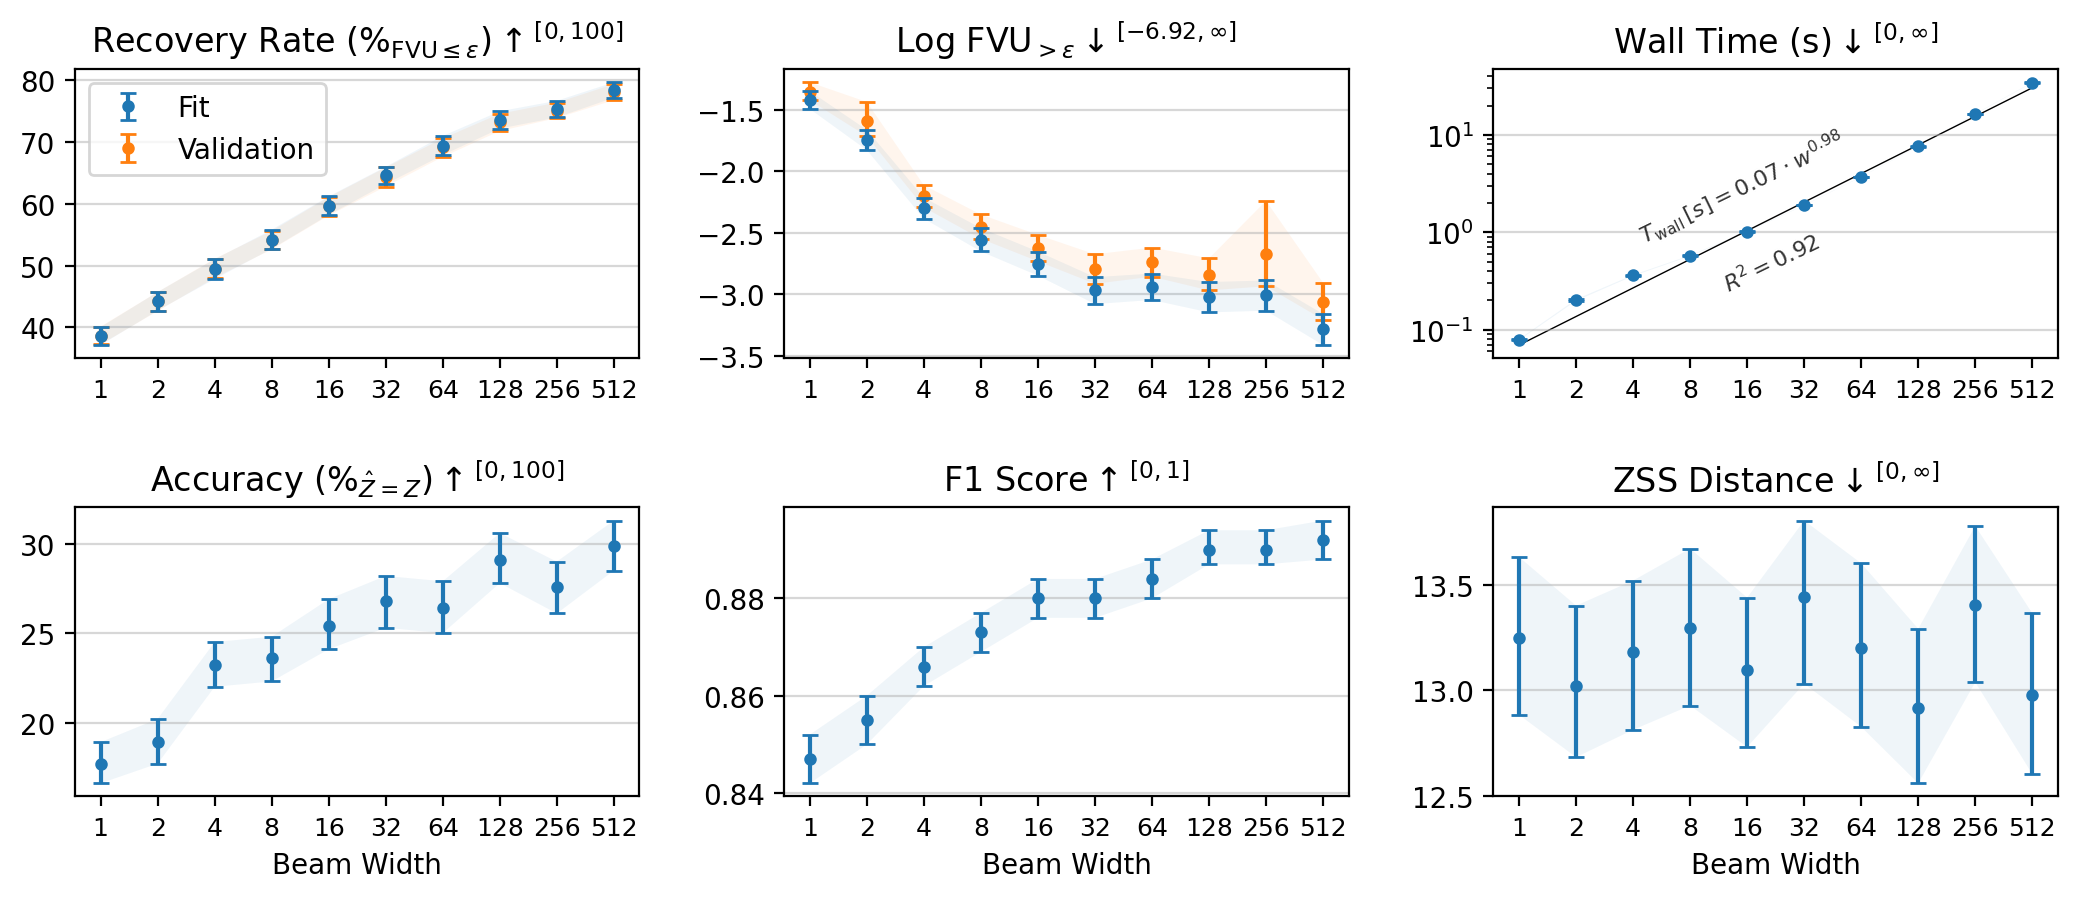

In [137]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'wall_time', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Wall Time (s)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
yscale_list = ['linear', 'linear', 'log', 'linear', 'linear', 'linear']
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [None] * len(show_metric_list)

x = [configs[model]['beam_width'] for model in MODELS]

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2.3), dpi=200)

showed_val_legend = False

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, objective, bounds, yscale) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, objective_list, bounds_list, yscale_list)):

    show_metrics = [show_metric]
    if f'{show_metric}_val' in total_summary_tables[sub_metric]['median'].T.index:
        show_metrics.append(f'{show_metric}_val')
    
    for k, (s, label) in enumerate(zip(show_metrics, ['Fit', 'Validation'])):
        y = total_summary_tables[sub_metric]['median'].T.loc[s] * factor
        y_lower = total_summary_tables[sub_metric]['lower'].T.loc[s] * factor
        y_upper = total_summary_tables[sub_metric]['upper'].T.loc[s] * factor

        ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3, zorder=3 + len(show_metrics) - k, label=label)
        sorted_indices = np.argsort(x)
        ax.fill_between(np.array(x)[sorted_indices], np.array(y_lower)[sorted_indices], np.array(y_upper)[sorted_indices], alpha=0.07, zorder=len(show_metrics) - k)

    if not showed_val_legend:
        ax.legend(loc='upper left')
        showed_val_legend = True

    ax.set_xscale('log', base=2)
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=9)

    if i // COLS == ROWS - 1:
        ax.set_xlabel('Beam Width')

    if show_metric == 'wall_time':
        x_logspace = np.logspace(np.log2(min(x)), np.log2(max(x)), 100, base=2)
        y_fit = np.exp(linear(np.log(x_logspace), *popt))
        ax.plot(x_logspace, y_fit, color='black', linewidth=0.5, label='Fit', zorder=1, alpha=1)
        ax.annotate(f'$T_{{\\text{{wall}}}}\,[s] = {popt[0]:.2f} \\cdot w^{{{popt[1]:.2f}}}$', (0.25, 0.4), xycoords='axes fraction', fontsize=8, rotation=26, alpha=0.8)
        ax.annotate(f'$R^2 = {1- fit_fvu:.2f}$', (0.4, 0.23), xycoords='axes fraction', fontsize=8, rotation=26, alpha=0.8)

    ax.grid(alpha=0.5, axis='y', zorder=2)

    ax.set_yscale(yscale)

    ax.set_ylim(ylim)

for ax in axes.flatten()[len(show_metric_list):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_errorbars.svg'))

In [49]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary_lengths = {length: {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()} for length in range(32)}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 100

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data_lengths = {length: pd.concat([df[df['length_target'] == length] for test_set, df in model_dfs.items() if test_set in aggregate_sets]) for length in range(32)}

    for length in tqdm(range(32)):
        for column in compare_columns:
            if column in aggregated_data_lengths[length].columns:
                data = aggregated_data_lengths[length][column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                total_summary_lengths[length][model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary_lengths[length][model][column].keys()

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6569/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1649: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  9%|▉         | 3/32 [00:00<00:06,  4.18it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_shape_base_impl.py:393: RuntimeWarning: All-NaN slice encountered
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_shape_base_impl.py:416: RuntimeWarning: All-NaN slice encountered
  buff[ind] = asanyarray(func1d(

In [50]:
total_summary_tables_length = {
    length: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    column: total_summary_lengths[length][model][column][metric][k]
                    for column in compare_columns}
                    for model in total_summary.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for length in range(32)}

In [51]:
from matplotlib.colors import LogNorm

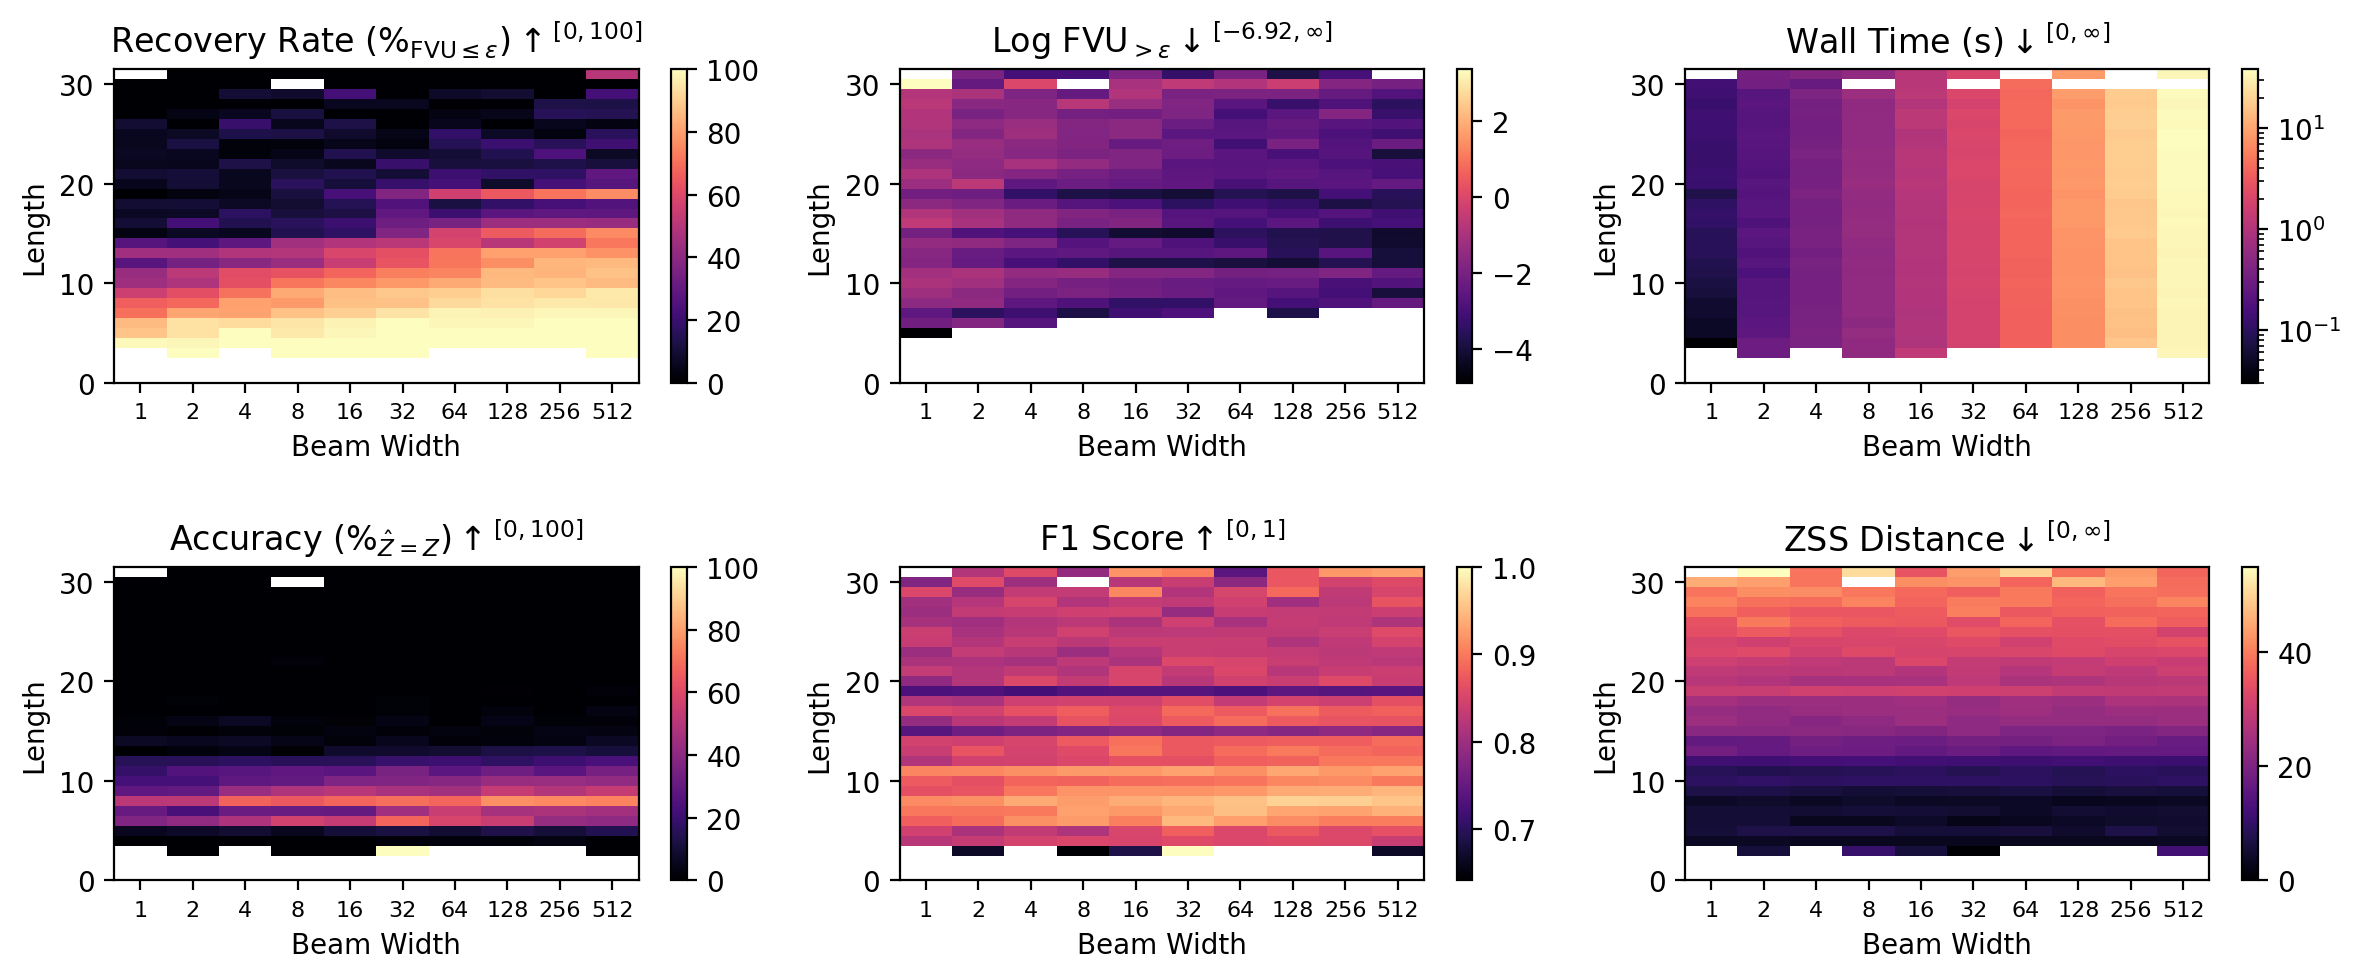

In [52]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'wall_time', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Wall Time (s)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
log_norm_list = [False, False, True, False, False, False]
ylim_list = [(0, 31.5)] * len(show_metric_list)

x = np.array([configs[model]['beam_width'] for model in MODELS])
sorted_indices = np.argsort(x)

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 2.5), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, log_norm, bounds, objective) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, log_norm_list, bounds_list, objective_list)):
    y = np.array([s[sub_metric]['median'].T.loc[show_metric] for s in total_summary_tables_length.values()]) * factor

    mesh = np.meshgrid(np.log2(x[sorted_indices]), np.arange(32))
    colormesh = ax.pcolormesh(mesh[0], mesh[1], y[:, sorted_indices], shading='auto', cmap='magma', norm=LogNorm() if log_norm else None, linewidth=0, rasterized=True)
    # colormesh.set_edgecolor('face')


    ax.set_xticks(np.log2(x))
    ax.set_xticklabels(x, fontsize=8)

    ax.set_ylabel('Length')
    ax.set_xlabel('Beam Width')
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    
    # Add a little colorbar to each plot
    cb = plt.colorbar(colormesh, ax=ax)

    ax.set_ylim(ylim)

# hist_x = np.arange(32)
# hist_y = [len(aggregated_data_lengths[length]) for length in range(32)]

# hist_plot_x = np.empty(2 * len(hist_x))
# hist_plot_x[0::2] = hist_x - 0.5
# hist_plot_x[1::2] = hist_x + 0.5
# hist_plot_y = np.empty(2 * len(hist_y))
# hist_plot_y[0::2] = hist_y
# hist_plot_y[1::2] = hist_y

# axes.flatten()[-1].fill_betweenx(hist_plot_x, hist_plot_y, color='k', alpha=0.2)
# axes.flatten()[-1].set_xlim(0, None)
# axes.flatten()[-1].set_xlabel('Number of Test Equations')
# axes.flatten()[-1].set_ylabel('Length')
# axes.flatten()[-1].grid(alpha=0.5)
# axes.flatten()[-1].set_ylim(0, 32)
# axes.flatten()[-1].set_title('Aggregated Test Set Distribution')

# Add a phantom colorbar
# cb = plt.colorbar(colormesh, ax=axes.flatten()[-1])
# Hide the colorbar
# cb.ax.set_visible(False)

fig.tight_layout(w_pad=1, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_length_heatmap.svg'))